In [2]:
import sys
sys.path.append('../../data')
sys.path.append('../../model')
from load import *
from losses import *
from utils import *
from enum import Enum
from model import DynamicUnet

import numpy as np

# import os
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader

from PIL import Image

from torchvision import models, transforms
import matplotlib.pyplot as plt
from pathlib import Path

from metrics import psnr, ssim

In [3]:
# Computer SPECS
gpu_id = 4
num_cores = 4
torch.cuda.set_device(gpu_id)

In [7]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/')
lr_path = f'EM/training/trainsets/lr/'
hr_path = f'EM/training/trainsets/hr/'
# model_path = data_pth/f'EM/models/feat_loss/'

# loading 3 rounds of data
bs_1 = 64
size_1 = 128
db = get_data(data_pth=data_pth, lr_dir=lr_path, hr_dir=hr_path,
             bs=bs_1, in_sz=size_1, out_sz=size_1, max_zoom=6)

In [10]:
superres_metrics = [F.mse_loss, psnr, ssim]

In [14]:
arch = models.resnet34(True)
size = size_1
encoder_arch = nn.Sequential(*list(arch.children())[:-2])

nt = Enum('NormType', 'Batch BatchZero Weight Spectral')

model = DynamicUnet(encoder_arch, n_classes=1, 
                    img_size=(size,size), norm_type=nt.Weight)

In [15]:
loss_function = F.mse_loss
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [24]:
dl = db.train_dl.dl

In [25]:
# %debug
num_epochs = 1
print_every = 10
running_loss = 0.0
model.cuda()
for i in range(num_epochs):
    for j, sample_batch in enumerate(dl):
        # get the inputs; data is a list of [inputs, labels]
        inputs, targets = sample_batch
        inputs = inputs.cuda()
        targets = targets.cuda()

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        preds = model(inputs)
        loss = loss_function(preds, targets)
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if j % (print_every) == 0:
            print(f'Epoch {i+1} Batch {j+1} loss: {running_loss/print_every}')
            running_loss = 0.0

/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/ipykernel_launcher.py:18: UserWarning: Using a target size (torch.Size([64, 3, 128, 128])) that is different to the input size (torch.Size([64, 1, 128, 128])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.


Epoch 1 Batch 1 loss: 0.4226707458496094
Epoch 1 Batch 11 loss: 0.33694333434104917
Epoch 1 Batch 21 loss: 0.040921473689377305
Epoch 1 Batch 31 loss: 0.020157583709806203
Epoch 1 Batch 41 loss: 0.011887622997164726
Epoch 1 Batch 51 loss: 0.00844094306230545
Epoch 1 Batch 61 loss: 0.007217637170106173
Epoch 1 Batch 71 loss: 0.0064761143177747725
Epoch 1 Batch 81 loss: 0.0060954004991799595
Epoch 1 Batch 91 loss: 0.005799569049850106
Epoch 1 Batch 101 loss: 0.005583442142233252
Epoch 1 Batch 111 loss: 0.005380992498248816
Epoch 1 Batch 121 loss: 0.005295089911669493
Epoch 1 Batch 131 loss: 0.0051087458617985245
Epoch 1 Batch 141 loss: 0.005110595747828484
Epoch 1 Batch 151 loss: 0.005073162214830518
Epoch 1 Batch 161 loss: 0.004837005957961082
Epoch 1 Batch 171 loss: 0.0048363757319748405
Epoch 1 Batch 181 loss: 0.004787742393091321
Epoch 1 Batch 191 loss: 0.004773547174409032
Epoch 1 Batch 201 loss: 0.004706291388720274
Epoch 1 Batch 211 loss: 0.004622010421007872
Epoch 1 Batch 221 los

In [30]:
global x, y

In [31]:
for i, batch in enumerate(dl):
    if i==3:
        x, y = batch
        break

In [33]:
x.shape

torch.Size([64, 3, 128, 128])

In [34]:
y.shape

torch.Size([64, 3, 128, 128])

In [43]:
pred = model(x.cuda())

In [45]:
pred.shape

torch.Size([64, 1, 128, 128])

In [46]:
x_viz, y_viz, pred_viz = x[0], y[0], pred[0]

In [51]:
def show_result(x, y, pred, figsize=(20,20)):
    """A helper function to visualize data samples."""
    f, axarr = plt.subplots(1,3, figsize=figsize)  # create visualizations
    axarr[0].imshow(x.permute(1,2,0)) # visualize image tensor
    axarr[0].set_title('Input')
    axarr[1].imshow(y.permute(1,2,0).squeeze(), cmap=plt.cm.gray) # visualize image tensor
    axarr[1].set_title('Target')
    axarr[2].imshow(pred.permute(1,2,0).squeeze(), cmap=plt.cm.gray) # visualize image tensor
    axarr[2].set_title('Prediction')

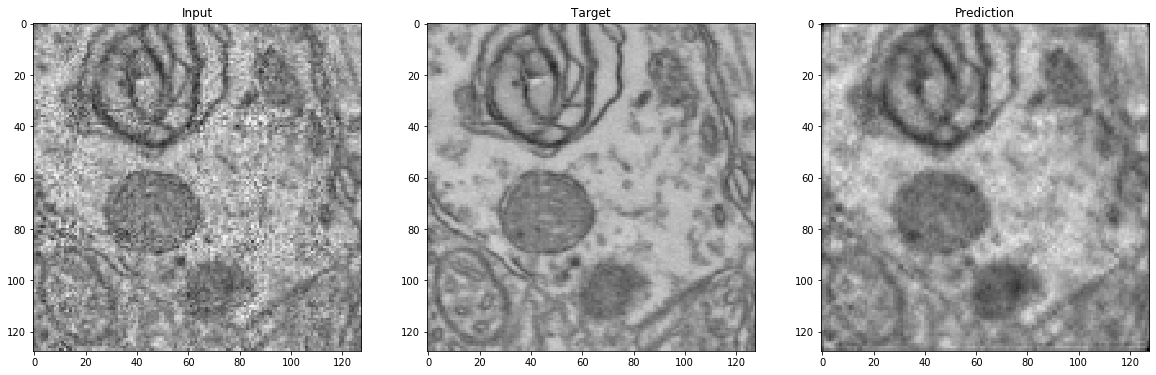

In [52]:
show_result(x_viz, y_viz, pred_viz)